# Evaluation of Learned Decoder
The purpose of this notebook is to evaluate the effectiveness of the learned decoders from CNN and GAN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA
from utils import Noise_dB, Normalize_01

# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [4]:
# Create params dict
date = '2024-01-11'#str(datetime.datetime.now().date())
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 10,
    "model": f"decoder_cnn_{date}",
    "dataset": "mnist_mura_noiseless",
    "scheduler_patience": 2,
    "snr": None, 
}
wandb.config = params

In [5]:
# Define transforms
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                # Noise_dB(desired_snr=params['snr']),
                # transforms.Normalize(0, 1),
                Normalize_01(),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

In [6]:
# Load dataset
mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=True)

loaders = {}
# Define DataLoader
loaders['train'] = DataLoader(mnist_mura, batch_size=1, shuffle=False)

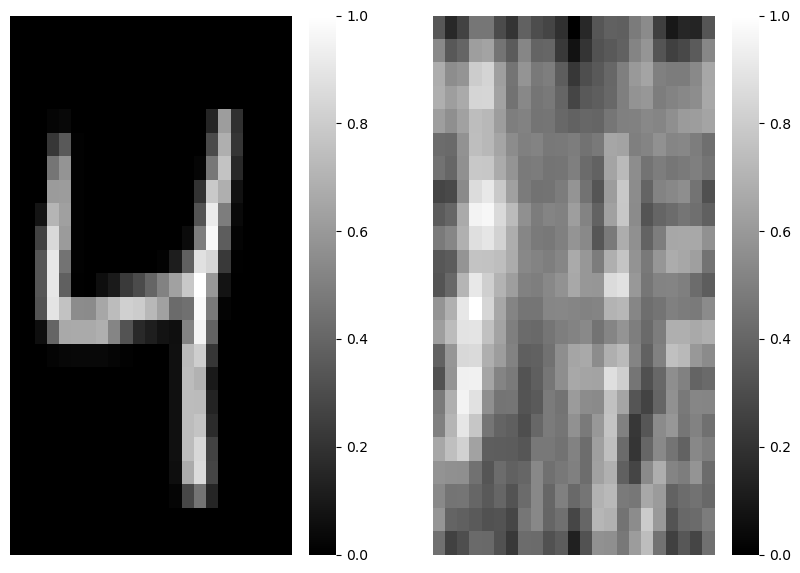

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=2
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Define Model

In [8]:
class RECON_CNN(torch.nn.Module):
    '''
    Define a model with only one convolutional layer, NO activation function, and NO bias
    '''
    def __init__(self, params):
        super().__init__() 
        
        # Define model basic info -- gets model/data parameters from dictionary params
        self.params = params
        self.img_size = self.params['image_size']
        self.kernel_size = self.params['image_size'] if self.params['image_size'] is not None else self.params['kernel_size']
        self.params["kernel_size"] = self.kernel_size
        self.criterion = torch.nn.MSELoss() if self.params.get('loss') is None else torch.nn.L1Loss() #
        self.params['model_save_path'] = f'../models/learned_decoder_cnn/{params["model"]}.pth'
        # if os.path.exists(self.params["model_save_path"]):
        #     self.load_state_dict(torch.load(self.params["model_save_path"]))
        #     print("Weights loaded from {}".format(self.params["model_save_path"]))
        
        # Define model architecture elements
        # Padding is circular -- mathematical motivation
        self.conv  = torch.nn.Conv2d(1,1,kernel_size=self.kernel_size, padding='same', padding_mode='circular', bias=False)#(self.kernel_size-1)//2)
        print("Using the following parameters:")
        for key, val in self.params.items():
            print(f"{key}: {val}")
        
    def forward(self, x):
        output = self.conv(x)
        return output

In [9]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate'])
model.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, 'min',patience=model.params['scheduler_patience'])

RUN_DIR = path+f'runs/{model.params["model"]}/'
# LOAD MODEL
# model.load_state_dict(torch.load('../models/learned_decoder_cnn/decoder_cnn.pth'))
model.load_state_dict(torch.load(RUN_DIR+f"{model.params['model']}.pth"))

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-01-11
dataset: mnist_mura_noiseless
scheduler_patience: 2
snr: None
kernel_size: 23
model_save_path: ../models/learned_decoder_cnn/decoder_cnn_2024-01-11.pth


<All keys matched successfully>

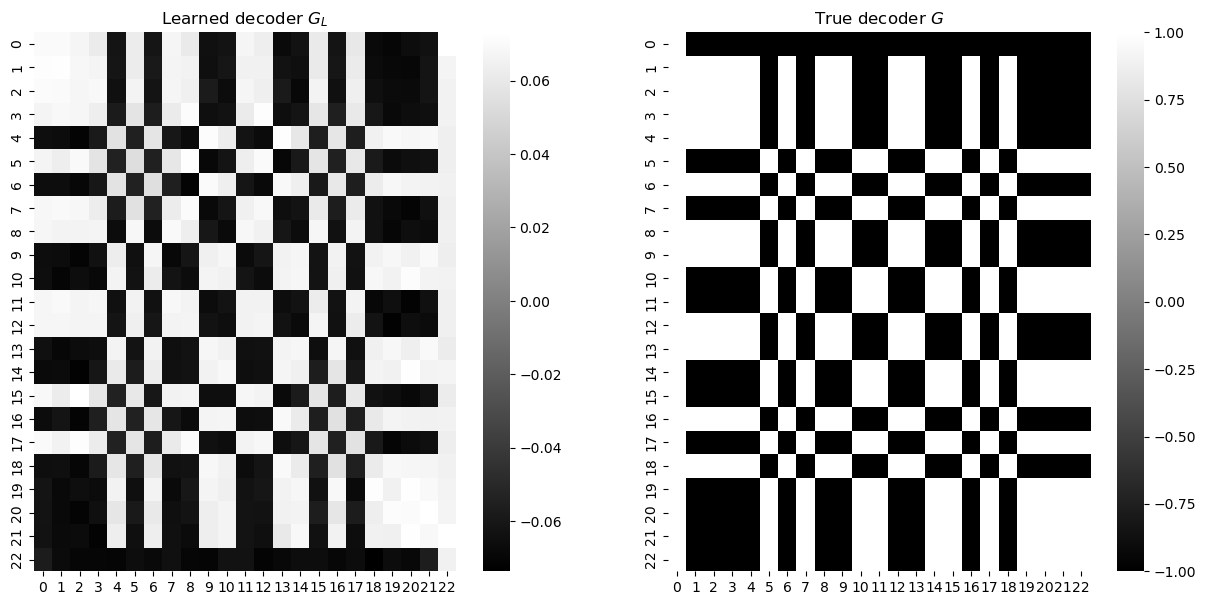

In [11]:
# Pot weights
weight_map = list(model.parameters())[0].cpu().detach().squeeze(0).squeeze(0)
fig, axs = plt.subplots(1,2, figsize = (15,7))
sns.heatmap(weight_map, cmap='gray', ax=axs[0])
sns.heatmap(mnist_mura.G, cmap='gray', ax=axs[1])

axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
# fig.savefig('../figs/learned_decoder_cnn_20_epochs_circular_pad.png')

plt.show()

# Test set evaluation

In [12]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [13]:
SSIM = StructuralSimilarityIndexMeasure()

In [32]:
# This is to load test sets with different levels of noise. Change level of noise
model.params['snr'] = 1

# Define transforms 
train_transform_list =[transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Resize(params['image_size'], antialias=True), 
                      ]
# For noiseless data, just normalize values between [0,1]
# If noise, add desired SNR noise
if model.params.get('snr') is None: 
    train_transform_list.append(Normalize_01())
else:
    train_transform_list.append(Noise_dB(desired_snr=model.params['snr']))
    train_transform_list.append(Normalize_01())

train_transform = transforms.Compose(train_transform_list)
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

# Define test set
test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=train_transform, target_transform=target_transform, train=False)
testset = DataLoader(test_mnist_mura, batch_size=10, shuffle=True)

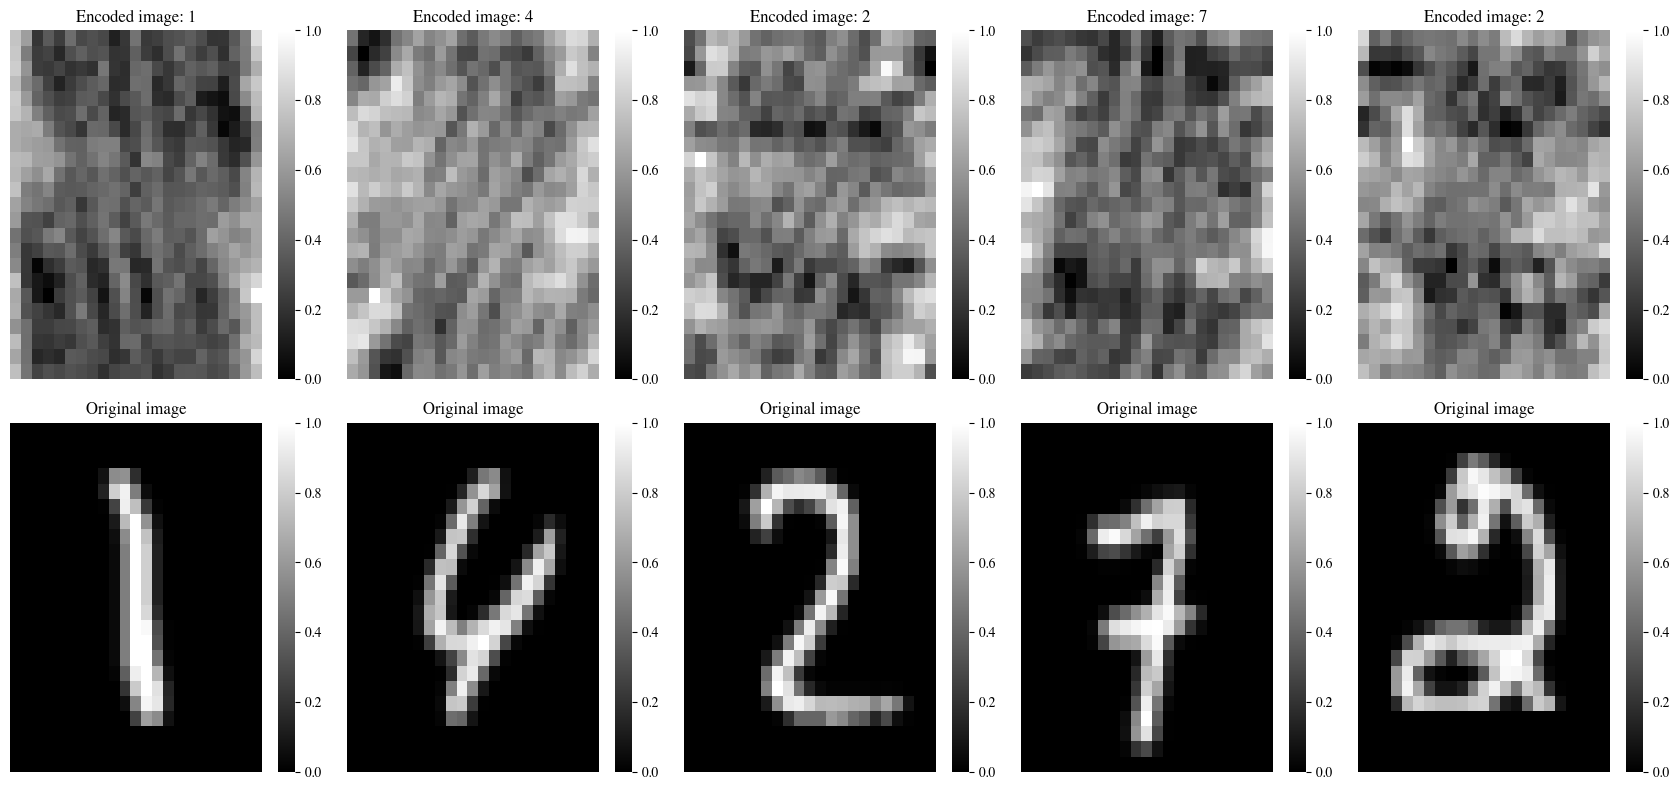

In [15]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
# plt.savefig(RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

# Calculate results with model

In [36]:
# Save MSE and SSIM evaluations in list
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item(), model.params['snr']))
    # show_outputs(outputs, targets, inputs, iterator=i)

In [37]:
# Put results in dataframe
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim','snr'])
df.head(5)

,inputs,outputs,targets,digits,mse,ssim,snr
0,"[[[tensor([0.4284, 0.4613, 0.4046, 0.2824, 0.4...","[[[tensor([ 0.2352, 0.0389, 0.2310, -0.0638,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(0), tensor(6), tensor(7), tensor(6), t...",0.042460,0.643673,1
1,"[[[tensor([0.3332, 0.2621, 0.1043, 0.3249, 0.5...","[[[tensor([ 0.5176, 0.1761, -0.0462, -0.1924,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(9), tensor(0), tensor(3), tensor(2), t...",0.046376,0.647146,1
2,"[[[tensor([0.3001, 0.4468, 0.5610, 0.3580, 0.3...","[[[tensor([-0.0866, 0.4403, 0.3330, -0.0392,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(7), tensor(1), tensor(3), tensor(7), t...",0.041002,0.631419,1
3,"[[[tensor([0.8260, 0.6795, 0.3710, 0.5124, 0.3...","[[[tensor([-1.8885e-01, 1.4063e-01, 2.5963e-...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(5), tensor(1), tensor(0), tensor(0), t...",0.044838,0.642144,1
4,"[[[tensor([0.5406, 0.5192, 0.4102, 0.4531, 0.3...","[[[tensor([ 0.0311, -0.0765, 0.2392, 0.4839,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(6), tensor(8), tensor(3), tensor(0), t...",0.046255,0.663540,1


# Plot results

In [38]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

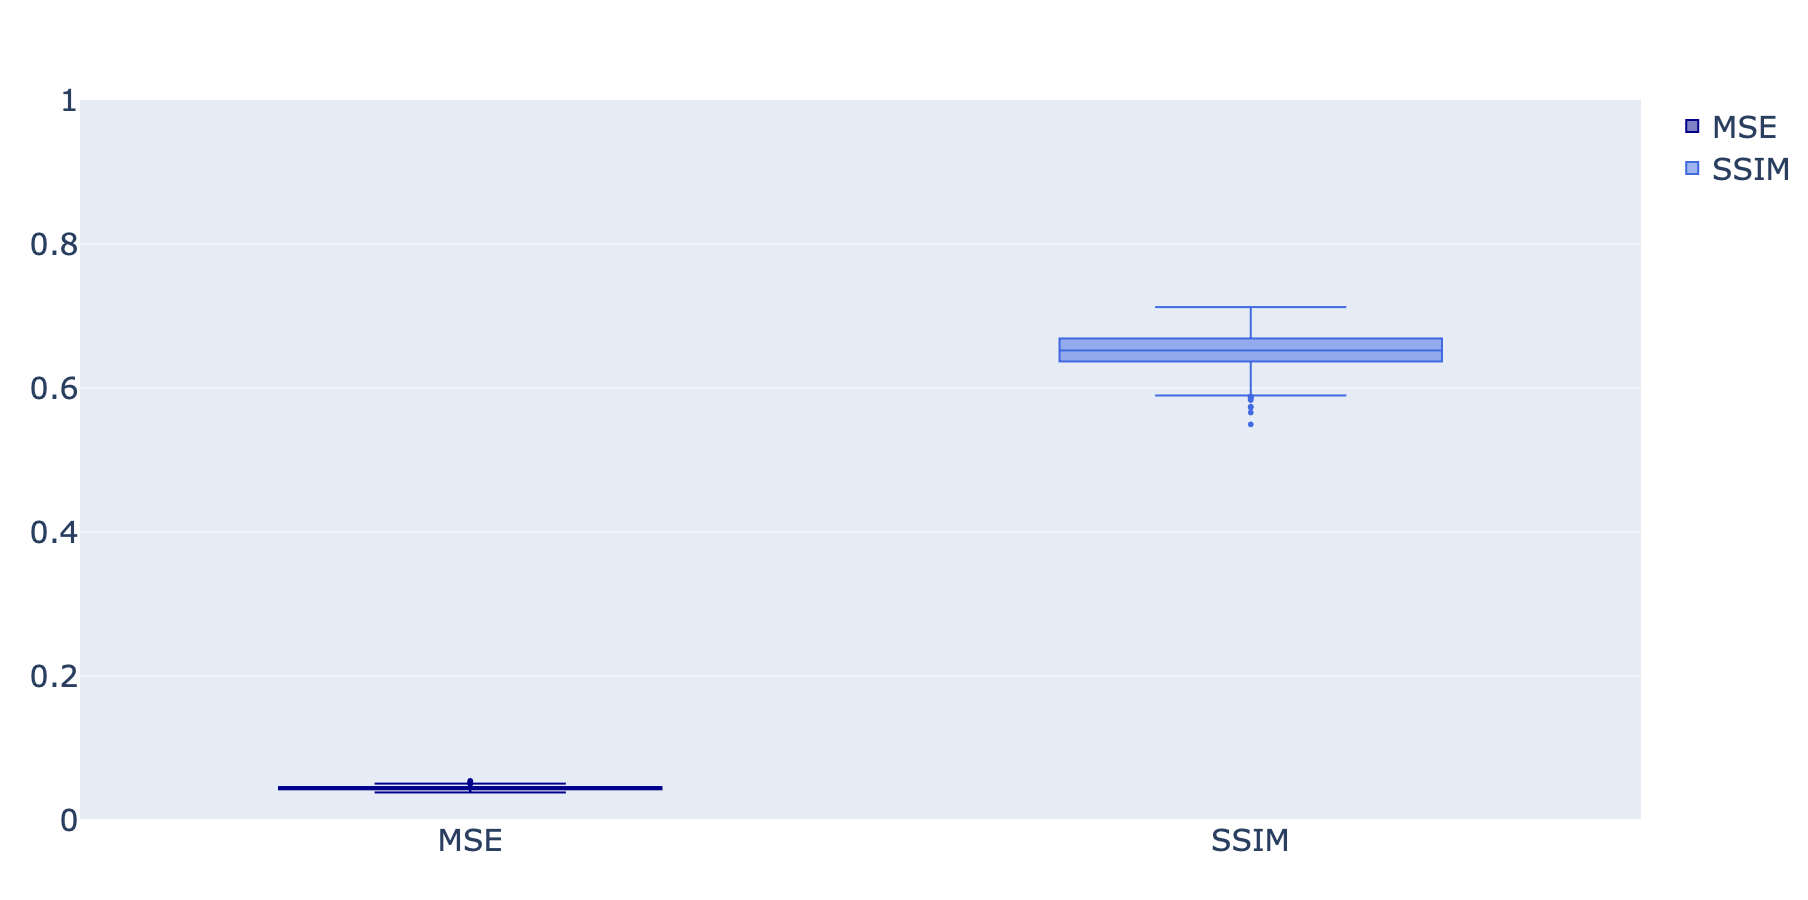

In [39]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
# fig.write_image(RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')

# Deconvolution method

In [42]:
D = testset.dataset[10]['img']
fft_D = torch.fft.fft2(D.squeeze(0))
fft_A = torch.fft.fft2(torch.Tensor(mnist_mura.A))
invert = torch.fft.ifft2(fft_D/fft_A)
recenter = torch.roll(invert, [int((model.img_size-1)/2),int((model.img_size-1)/2)], dims=(0,1))

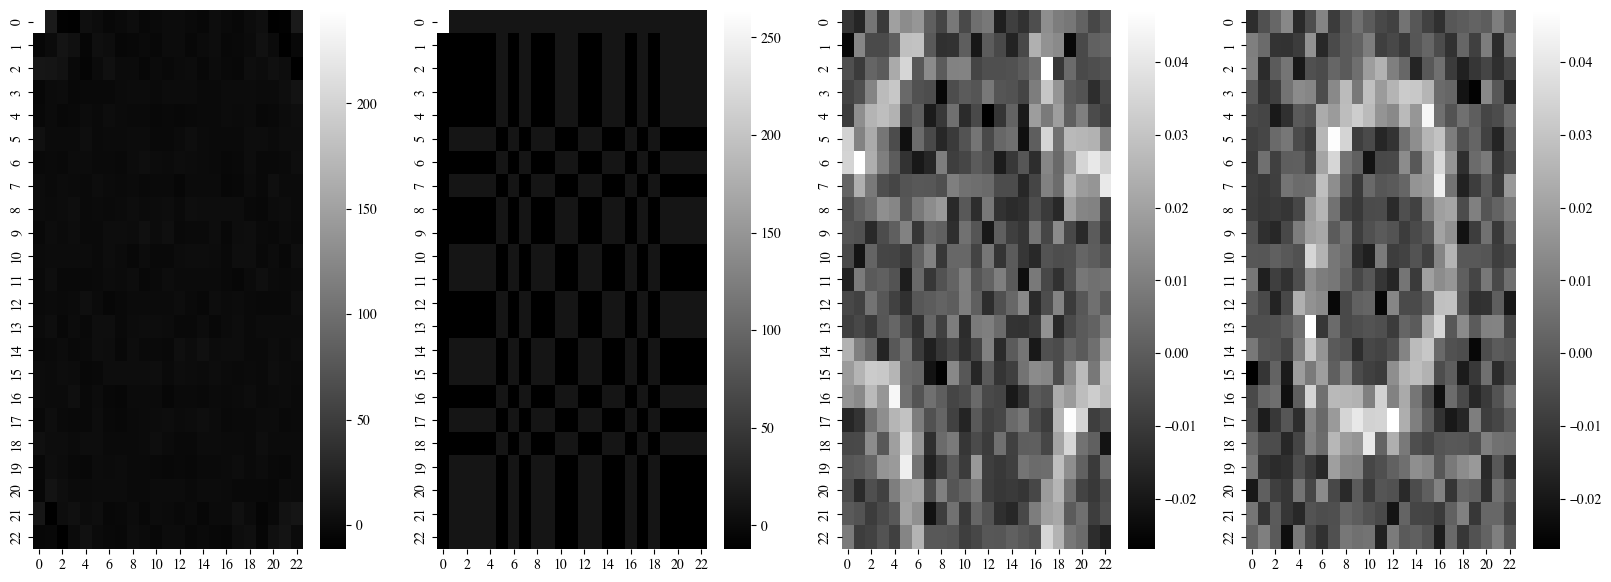

In [47]:
fig, axs = plt.subplots(1,4, figsize= (20,7))
axs = axs.ravel()
sns.heatmap(fft_D.real, ax=axs[0], cmap='gray')
sns.heatmap(fft_A.real, ax=axs[1], cmap='gray')
sns.heatmap(invert.real, ax=axs[2], cmap='gray')
sns.heatmap(recenter.real, ax=axs[3], cmap='gray')
plt.show()

# Rotate the weights

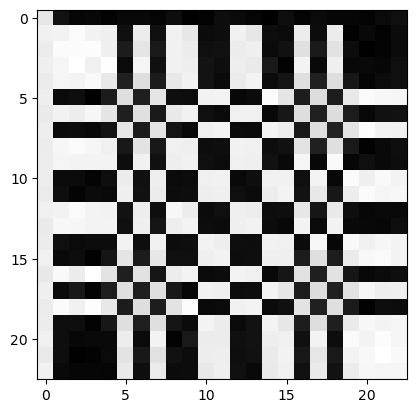

In [42]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [28]:
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(11,11,11,11), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

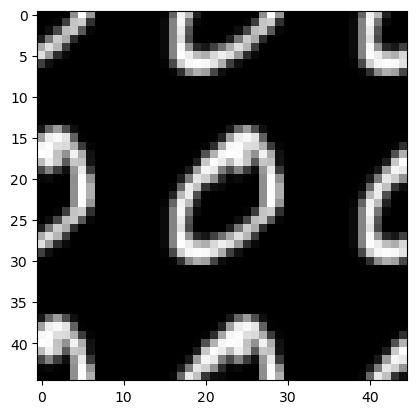

In [34]:
plt.imshow(padded_ex, cmap='gray')
plt.show()